## Importing the libraries

In [1]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Getting Path

In [2]:
path = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

In [3]:
filepath = os.listdir(path)
print(filepath)

['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Segmentation_example_script.m', 'README.txt', 'Striped Red Mullet', 'license.txt', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']


In [4]:
categories = ['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']

## Creating a image database

In [5]:
image_path = []
fish_category =  []
for i in categories:
    for j in os.listdir(os.path.join(path+'/'+i+'/'+i)):
        image_path.append(os.path.join(path+'/'+i+'/'+i+'/'+j))
        fish_category.append(i)
    

In [6]:
df = {'image_path':image_path,'category':fish_category}
df = pd.DataFrame(df)

In [7]:
df.to_csv('train.csv')

## Importing the deeplearning libraries

In [8]:
import torch 
from torchvision import transforms as T
from torchvision import models
import PIL 
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

## Building the fishDatasetClass

In [9]:
class fishDataset(Dataset):
    def __init__(self,dataframe,transform):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe.image_path)
    
    def __getitem__(self,idx):
        image = PIL.Image.open(self.dataframe.image_path[idx])
        image = transform(image)
        target = self.dataframe.category_number[idx]
        return image,target

In [10]:
train_transform = transform = T.Compose([T.Resize(256),T.CenterCrop(224),T.ToTensor(),T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
valid_transform = transform = T.Compose([T.Resize(256),T.CenterCrop(224),T.ToTensor(),T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [11]:
df_train = pd.read_csv('./train.csv')
df_train= df_train.sample(frac=1).reset_index(drop=True)

In [12]:
df_train.category.value_counts()

Hourse Mackerel       1000
Striped Red Mullet    1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Black Sea Sprat       1000
Red Mullet            1000
Trout                 1000
Name: category, dtype: int64

In [13]:
category_map={}
for i,j in enumerate(list(set(df_train.category))):
    category_map[j]=i

In [14]:
df_train['category_number'] = df_train['category'].map(category_map)

In [15]:
from sklearn.model_selection import train_test_split
df_train,df_valid = train_test_split(df_train,test_size=0.2,random_state=42)

In [16]:
df_train.reset_index(drop=True,inplace=True)
df_valid.reset_index(drop=True,inplace=True)

In [17]:
trainDataset = fishDataset(df_train,transform=train_transform)
validDataset = fishDataset(df_valid,transform=valid_transform)

Text(0.5, 1.0, '1')

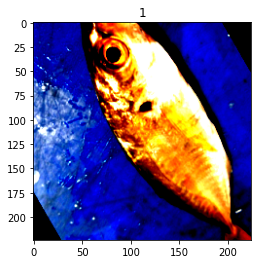

In [18]:
image,label = next(iter(trainDataset))
plt.imshow(np.transpose(np.array(image),(1,2,0)))
plt.title(label)

In [19]:
trainLoader = DataLoader(trainDataset,batch_size=64,shuffle=True)
validLoader = DataLoader(validDataset,batch_size=64,shuffle=False)

## Importing pretrained model

In [20]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,9)
for param in model.fc.parameters():
    param.requires_grad = True
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"
print(device)

cuda


In [22]:
optimizer = torch.optim.Adam(model.fc.parameters(),lr= 0.001)
criterion = nn.CrossEntropyLoss()

In [23]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training and Validation

In [26]:
n_epochs = 20
valid_loss_min = np.Inf
for epoch in tqdm(range(1,n_epochs+1)):
    train_loss = 0.0
    valid_loss = 0.0
    train_running_correct= 0.0
    val_running_correct = 0.0
    
    model.train()
    
    for data,target in trainLoader:
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        _,preds = torch.max(output.data,1)
        train_running_correct += (preds==target).sum().item()
    
    model.eval()
    
    for data,target in validLoader:
        data,target = data.to(device),target.to(device)
        output = model(data)
        loss = criterion(output,target)
        valid_loss+=loss.item()*data.size(0)
        _,preds =torch.max(output.data,1)
        val_running_correct += (preds==target).sum().item()
        
    train_loss = train_loss/len(trainLoader.sampler)
    valid_loss = valid_loss/len(validLoader.sampler)
    train_accuracy = 100. * train_running_correct/len(trainLoader.sampler)
    valid_accuracy = 100. * val_running_correct/len(validLoader.sampler)
    print('Epoch: {} , Training Loss: {:.6f},Training Accuracy: {:.3f} ,Validation Loss: {:.6f}, Validation Accuracy: {:.3f}'.format(epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
    
    if valid_loss<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_fish.pt')
        valid_loss_min = valid_loss

        

  5%|▌         | 1/20 [02:08<40:40, 128.45s/it]

Epoch: 1 , Training Loss: 0.554633,Training Accuracy: 93.472 ,Validation Loss: 0.237159, Validation Accuracy: 97.944
Validation loss decreased (inf --> 0.237159).  Saving model ...


 10%|█         | 2/20 [04:16<38:31, 128.41s/it]

Epoch: 2 , Training Loss: 0.187893,Training Accuracy: 98.097 ,Validation Loss: 0.126464, Validation Accuracy: 98.833
Validation loss decreased (0.237159 --> 0.126464).  Saving model ...


 15%|█▌        | 3/20 [06:26<36:35, 129.14s/it]

Epoch: 3 , Training Loss: 0.116256,Training Accuracy: 98.931 ,Validation Loss: 0.083596, Validation Accuracy: 99.056
Validation loss decreased (0.126464 --> 0.083596).  Saving model ...


 20%|██        | 4/20 [08:36<34:30, 129.43s/it]

Epoch: 4 , Training Loss: 0.083648,Training Accuracy: 99.278 ,Validation Loss: 0.066900, Validation Accuracy: 99.111
Validation loss decreased (0.083596 --> 0.066900).  Saving model ...


 25%|██▌       | 5/20 [10:46<32:22, 129.51s/it]

Epoch: 5 , Training Loss: 0.067068,Training Accuracy: 99.292 ,Validation Loss: 0.051759, Validation Accuracy: 99.444
Validation loss decreased (0.066900 --> 0.051759).  Saving model ...


 30%|███       | 6/20 [12:55<30:11, 129.40s/it]

Epoch: 6 , Training Loss: 0.052351,Training Accuracy: 99.611 ,Validation Loss: 0.042864, Validation Accuracy: 99.556
Validation loss decreased (0.051759 --> 0.042864).  Saving model ...


 35%|███▌      | 7/20 [15:04<28:02, 129.39s/it]

Epoch: 7 , Training Loss: 0.048691,Training Accuracy: 99.431 ,Validation Loss: 0.037482, Validation Accuracy: 99.389
Validation loss decreased (0.042864 --> 0.037482).  Saving model ...


 40%|████      | 8/20 [17:13<25:50, 129.25s/it]

Epoch: 8 , Training Loss: 0.038976,Training Accuracy: 99.597 ,Validation Loss: 0.032811, Validation Accuracy: 99.667
Validation loss decreased (0.037482 --> 0.032811).  Saving model ...


 45%|████▌     | 9/20 [19:23<23:41, 129.21s/it]

Epoch: 9 , Training Loss: 0.034792,Training Accuracy: 99.708 ,Validation Loss: 0.028373, Validation Accuracy: 99.611
Validation loss decreased (0.032811 --> 0.028373).  Saving model ...


 50%|█████     | 10/20 [21:31<21:31, 129.14s/it]

Epoch: 10 , Training Loss: 0.031097,Training Accuracy: 99.667 ,Validation Loss: 0.026892, Validation Accuracy: 99.611
Validation loss decreased (0.028373 --> 0.026892).  Saving model ...


 55%|█████▌    | 11/20 [23:40<19:21, 129.05s/it]

Epoch: 11 , Training Loss: 0.027039,Training Accuracy: 99.792 ,Validation Loss: 0.023437, Validation Accuracy: 99.944
Validation loss decreased (0.026892 --> 0.023437).  Saving model ...


 60%|██████    | 12/20 [25:49<17:12, 129.01s/it]

Epoch: 12 , Training Loss: 0.025569,Training Accuracy: 99.792 ,Validation Loss: 0.021739, Validation Accuracy: 99.778
Validation loss decreased (0.023437 --> 0.021739).  Saving model ...


 65%|██████▌   | 13/20 [27:58<15:02, 128.97s/it]

Epoch: 13 , Training Loss: 0.021303,Training Accuracy: 99.875 ,Validation Loss: 0.020529, Validation Accuracy: 99.722
Validation loss decreased (0.021739 --> 0.020529).  Saving model ...


 70%|███████   | 14/20 [30:07<12:53, 128.85s/it]

Epoch: 14 , Training Loss: 0.019155,Training Accuracy: 99.861 ,Validation Loss: 0.021025, Validation Accuracy: 99.611


 75%|███████▌  | 15/20 [32:16<10:44, 128.85s/it]

Epoch: 15 , Training Loss: 0.018026,Training Accuracy: 99.889 ,Validation Loss: 0.017480, Validation Accuracy: 99.722
Validation loss decreased (0.020529 --> 0.017480).  Saving model ...


 80%|████████  | 16/20 [34:24<08:34, 128.70s/it]

Epoch: 16 , Training Loss: 0.016719,Training Accuracy: 99.931 ,Validation Loss: 0.015364, Validation Accuracy: 99.778
Validation loss decreased (0.017480 --> 0.015364).  Saving model ...


 85%|████████▌ | 17/20 [36:33<06:26, 128.85s/it]

Epoch: 17 , Training Loss: 0.015908,Training Accuracy: 99.819 ,Validation Loss: 0.014351, Validation Accuracy: 99.833
Validation loss decreased (0.015364 --> 0.014351).  Saving model ...


 90%|█████████ | 18/20 [38:41<04:17, 128.64s/it]

Epoch: 18 , Training Loss: 0.015392,Training Accuracy: 99.847 ,Validation Loss: 0.013850, Validation Accuracy: 99.722
Validation loss decreased (0.014351 --> 0.013850).  Saving model ...


 95%|█████████▌| 19/20 [40:50<02:08, 128.80s/it]

Epoch: 19 , Training Loss: 0.014726,Training Accuracy: 99.917 ,Validation Loss: 0.012965, Validation Accuracy: 99.889
Validation loss decreased (0.013850 --> 0.012965).  Saving model ...


100%|██████████| 20/20 [43:00<00:00, 129.01s/it]

Epoch: 20 , Training Loss: 0.013302,Training Accuracy: 99.861 ,Validation Loss: 0.011635, Validation Accuracy: 99.889
Validation loss decreased (0.012965 --> 0.011635).  Saving model ...
